In [5]:
from extractEvents import AnimalEventDetector
import matplotlib.pyplot as plt
import numpy as np

In [10]:
file_name  = './bird_audio_track.m4a'
amplitude_threshold = 0.06
min_event_duration = 1000
sample_rate = 44100
band = (370, 400)
ema_alpha=0.0001

In [11]:
detector = AnimalEventDetector(amplitude_threshold, min_event_duration, sample_rate, band, ema_alpha)
detector.load_audio(file_name)
events = detector.detect_events()
events

[(399891, 491290),
 (754089, 828630),
 (2006325, 2054653),
 (2059727, 2107727),
 (2141961, 2189961)]

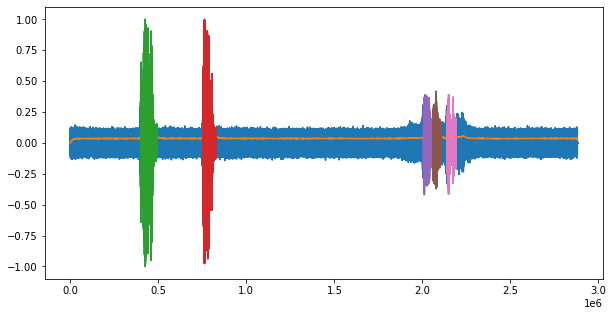

In [12]:
rng = np.arange(detector.audio_array.shape[0])
plt.figure(figsize=(10,5))
plt.plot(rng, detector.audio_array)
plt.plot(rng, detector.ema)
for event in detector.events:
    plt.plot(rng[event[0]:event[1]], detector.audio_array[event[0]:event[1]])

In [24]:
from pydub import AudioSegment
import os
from scipy.signal import correlate

def load_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    max_amplitude = np.max(np.abs(samples))
    if max_amplitude > 0:
        samples = samples / max_amplitude
    return samples

path = '../data'
correlations = {event[0]: {} for event in detector.events}
for file in os.listdir(path):
    animal = file.split('.')[0].replace('_', ' ')
    sample = load_audio(path+'/'+file)
    for event in detector.events:
        signal = detector.audio_array[event[0]:event[1]]
        correlation = correlate(signal, sample, mode='full')
        correlations[event[0]][animal] = np.max(correlation)

In [75]:
import pandas as pd
# df = pd.DataFrame(correlations)
df.to_csv('../correlations.csv')

In [67]:
df.idxmax()

399891     Haematopus palliatus
754089      Cyanocitta stelleri
2006325    Sphyrapicus nuchalis
2059727    Sphyrapicus nuchalis
2141961     Auriparus flaviceps
dtype: object

In [74]:
df.sort_values(399891).tail(30)

,399891,754089,2006325,2059727,2141961
Calamospiza melanocorys,334.931763,243.418106,94.590050,71.685951,19.478325
Numenius phaeopus,336.509094,422.933533,80.889328,52.441998,23.745884
Porphyrio poliocephalus,343.984070,320.522675,83.473808,53.760059,26.351130
Oenanthe oenanthe,349.552246,194.992783,108.715927,81.015457,46.785587
Vireo vicinior,372.466064,428.254852,143.628510,134.276321,21.943933
Larus hyperboreus,380.259705,575.745667,47.762337,34.375492,24.824905
Baeolophus atricristatus,381.210785,182.414902,126.961113,138.251495,21.487421
Colaptes auratus,399.506622,537.972595,65.125336,49.264923,18.290480
Larus brachyrhynchus,418.065979,449.073914,51.306526,67.215942,20.225277
Zenaida asiatica,429.119843,459.372955,59.027702,51.579597,21.065252


In [44]:
import requests

query_params = {
    'grp' : 'birds',
    'cnt' : 'united_states',
    'stage' : 'adult',
    'gen': 'Ixoreus'
}
query = '+'.join([param + ':' + query_params[param] for param in query_params])

api = f'https://xeno-canto.org/api/2/recordings?query={query}'
file_data = requests.get(api).json()
file_data

{'numRecordings': '21',
 'numSpecies': '1',
 'page': 1,
 'numPages': 1,
 'recordings': [{'id': '750456',
   'gen': 'Ixoreus',
   'sp': 'naevius',
   'ssp': '',
   'group': 'birds',
   'en': 'Varied Thrush',
   'rec': 'AUDEVARD Aurélien',
   'cnt': 'United States',
   'loc': 'Homer, Kenai Peninsula Borough, Alaska',
   'lat': '59.6874',
   'lng': '-151.4724',
   'alt': '420',
   'type': 'song',
   'sex': 'male',
   'stage': 'adult',
   'method': 'field recording',
   'url': '//xeno-canto.org/750456',
   'file': 'https://xeno-canto.org/750456/download',
   'file-name': 'XC750456-Grive a collier male chant 1 20062022 - Homer - Alaska.mp3',
   'sono': {'small': '//xeno-canto.org/sounds/uploaded/YPDXKAZUZN/ffts/XC750456-small.png',
    'med': '//xeno-canto.org/sounds/uploaded/YPDXKAZUZN/ffts/XC750456-med.png',
    'large': '//xeno-canto.org/sounds/uploaded/YPDXKAZUZN/ffts/XC750456-large.png',
    'full': '//xeno-canto.org/sounds/uploaded/YPDXKAZUZN/ffts/XC750456-full.png'},
   'osci': {'sma

In [56]:
recording = sorted(file_data['recordings'], key= lambda x: 60*int(x['length'].split(':')[0])+int(x['length'].split(':')[1]))[2]
animal = recording['gen'] + '_' + recording['sp']
with requests.get(recording['file'], allow_redirects=True, stream=True) as r:
    with open(f"../data/{animal}.mp3", "wb") as f:
        f.write(r.content)


In [57]:
print(animal)

Ixoreus_naevius
